In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import multivariate_normal

Prepare dataset for experiments

In [16]:
nb_samples = 1000
nb_unlabeled = 900
random_state = 42
n_class = 3

In [55]:
X, y = make_blobs(n_samples=nb_samples, n_features=2, centers=n_class, cluster_std=3, random_state=random_state)
y_true = y.copy()

In [56]:
y[:15]

array([2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 0, 2, 0, 1, 1])

Set unknown label for random instances

In [57]:
np.random.seed(random_state)
unlabeled_idx = np.random.choice(np.arange(0, nb_samples, 1), replace=False, size=nb_unlabeled,)
y[unlabeled_idx] = -1

In [58]:
y[:15]

array([-1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1])

Plot dataset

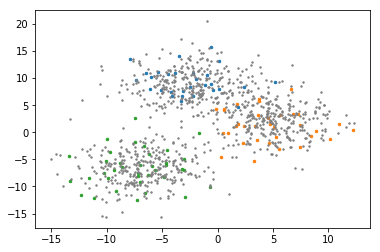

In [59]:
def plot_dataset():
    for i in range(n_class):
        plt.scatter(X[y==i, 0], X[y==i, 1], s=6)
    
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='grey', s=2)
    
plot_dataset()

Generate random distributions

In [60]:
means, covariances = [], []

for i in range(n_class):
    means.append(np.random.uniform(-7.5, 10.0, size=2))
    c_ = np.random.uniform(5.0, 15.0, size=(2, 2))
    # For quadratic form - positive semidefine
    c_ = np.dot(c_, c_.T)
    covariances.append(c_)
    
means = np.array(means)
covariances = np.array(covariances)
covariances = np.sqrt(covariances)
quantities =  np.unique(y_true, return_counts=True)[1]
quantities = quantities / np.sum(quantities)

In [61]:
quantities

array([0.334, 0.333, 0.333])

In [62]:
means[0]

array([ 9.82430407, -1.85880771])

In [63]:
covariances[0]

array([[15.11705521, 15.80708512],
       [15.80708512, 17.27461415]])

Plot intial clusters

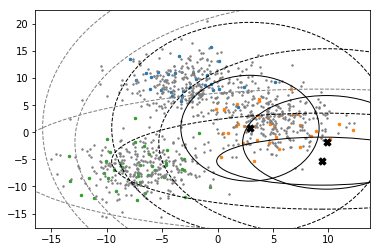

In [64]:
def plot_distribution(m, c, ax):
    ax.scatter(m[0], m[1], s=50, c='black', marker='X')
    c0 = c[0]
    c1 = c[1]
    ell1 = Ellipse(m, c0, c1, fill=False, edgecolor='black', lw=1)
    ell2 = Ellipse(m, 2*c0, 2*c1, fill=False, edgecolor='black', ls='dashed')
    ell3 = Ellipse(m, 3*c0, 3*c1, fill=False, edgecolor='grey', ls='dashed')
    ax.add_artist(ell1)
    ax.add_artist(ell2)
    ax.add_artist(ell3)

fig, ax = plt.subplots()    
plot_dataset()

for i in range(n_class):
    plot_distribution(means[i], np.diag(covariances[i]), ax)

Implement Gaussian Mixture Model

In [65]:
class SimpleGaussianMixture(object):
    def __init__(self, n_iterations, init_means, init_covariance_matrix, q):
        self.n_iters = n_iterations
        self.means_ = init_means
        self.covariances_ = init_covariance_matrix
        self.quantities_ = q
    
    def fit(self, X, y):
        nb_samples = X.shape[0]
        nb_class = np.unique(y).shape[0] - 1
        
        for i in range(self.n_iters):
            Pij = np.zeros((nb_samples, nb_class))
            
            for i in range(nb_samples):
                # For unlabaled Model
                if y[i] == -1:
                    p = []
                    for _class in range(nb_class):
                        p_ = multivariate_normal.pdf(X[i], self.means_[_class], self.covariances_[_class], allow_singular=True)
                        p_ = p_ * self.quantities_[_class] + 1e-20
                        p.append(p_)
                    
                    Pij[i] = np.array(p) / np.sum(p)
                else:
                    Pij[i, y[i]] = 1.0
                    
            n = np.sum(Pij, axis=0)
            m = np.sum(np.dot(Pij.T, X), axis=0)
            means = []
            quantities = []
            covariances = np.zeros(self.covariances_.shape)
            self.pij = Pij
            
            for _class in range(nb_class):
                mean = np.dot(Pij[:, _class], X) / n[_class]
                means.append(mean)
                quantity = n[_class] / nb_samples
                quantities.append(quantity)
    
            for t in range(nb_samples):
                for _class in range(nb_class):
                    covariance = Pij[t, _class] * np.outer(X[t] - means[_class], X[t] - means[_class])
                    covariances[_class, :, :] += covariance 
                    
            for _class in range(nb_class):
                covariances[_class, :, :] = covariances[_class, :, :] / n[_class]
                
            self.means_ = np.array(means)
            self.covariances_ = covariances
            self.quantities_ = np.array(quantities)
    

In [66]:
simple_mg = SimpleGaussianMixture(25, means, covariances, quantities)
simple_mg.fit(X, y)

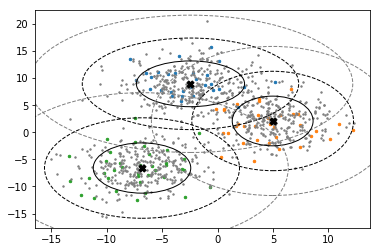

In [67]:
fig, ax = plt.subplots()    
plot_dataset()

for i in range(n_class):
    plot_distribution(simple_mg.means_[i], np.diag(simple_mg.covariances_[i]), ax)

Create Gaussian Mixture Model from Scikit-Learn

In [68]:
gm = GaussianMixture(n_components=n_class, 
                     covariance_type='diag', 
                     random_state=random_state, tol=1e-4)

gm.fit(X[y != -1], y[y != -1])

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.0001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Covariance matrix

In [69]:
gm.covariances_

array([[10.02989768,  9.14776579],
       [10.9424308 , 11.18462748],
       [ 6.52344517,  7.76724732]])

Means for predicted distribution

In [70]:
gm.means_

array([[-7.30093367, -7.00945748],
       [ 4.33143695,  1.61587258],
       [-3.20584291,  9.25938829]])

Plot predicted distribution

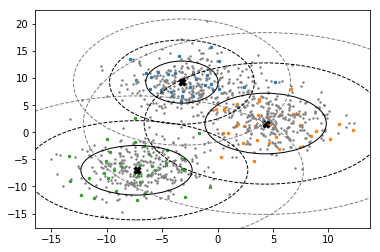

In [71]:
fig, ax = plt.subplots()    
plot_dataset()

for i in range(n_class):
    plot_distribution(gm.means_[i], gm.covariances_[i], ax)

Plot predicted clusters

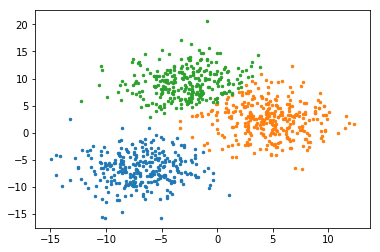

In [72]:
def plot_prediction(X, y_pred):
    for i in range(n_class):
        idx = y_pred==i
        plt.scatter(X[idx, 0], X[idx, 1], s=6)
        
plot_prediction(X[y==-1], gm.predict(X[y==-1]))

Try classifier with only labeled dataset

In [73]:
kmean = KNeighborsClassifier()
kmean.fit(X[y!=-1], y[y!=-1])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [74]:
print(classification_report(y_true[y == -1], kmean.predict(X[y == -1])))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       305
           1       0.91      0.97      0.94       299
           2       1.00      0.99      1.00       296

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



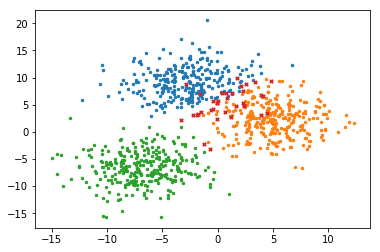

In [75]:
def plot_errors(X, y_true, y_pred):
    plt.scatter(X[y_pred!=y_true, 0], X[y_pred!=y_true, 1], s=12, marker='x')

y_pred = kmean.predict(X[y==-1])
plot_prediction(X[y==-1], y_pred)
plot_errors(X[y==-1], y_true[y==-1], y_pred)